## Frequency Shift Chirp Modulation: La modulación LoRa

LoRa emplea **Chirps** como base de cada símbolo modulado. Un **chirp** es una señal senoidal que aumenta o decrementa su frecuencia de forma lineal.


Cada símbolo $s(nT_s)$ es un numero real que se genera a partir de un vector binario $w(nT_s)$ de longitud igual al **Spreading Factor** (SF), el cual puede tomar valores entre 7 y 12.


- **Vector de bits**: $w(nT_s) = [w_0(nT_s), \dots, w_{\mathrm{SF}-1}(nT_s)]$, donde cada $w_h(nT_s) \in \{0, 1\}$.  

- **Combinaciones posibles**: este vector de $\mathrm{SF}$ bits admite $2^{\mathrm{SF}}$ símbolos distintos.



Para convertir el vector binario $w(nT_s)$ a un valor real $s(nT_s)$, usamos la siguiente  ecuación propuesta en el paper de Vangelista:

$$
s(nT_s) \;=\; \sum_{h=0}^{\mathrm{SF}-1} w_h(nT_s)\,\cdot\,2^{h}
$$

donde:

* $w_h(nT_s)$ es el bit en la posición $h$ del vector de bits $w(nT_s)$.

* Cada bit se multiplica por $2^h$ (su “peso”) y se suman todos los términos.


Podemos ver entonces que el símbolo $s(nT_s)$ puede tomar cualquiera de los valores enteros:

$$
s(nT_s) \;\in\; \{\,0, 1, 2, \dots, 2^{\mathrm{SF}} -1\}
$$




In [ ]:
import numpy as np

def generate_random_uniform_bits(sf, num_paquetes, ref):
    # Creamos una matriz de números aleatorios de tamaño (num_paquetes x sf)
    z = np.random.uniform(size=(num_paquetes, sf))
    
    # Generamos los bits con una probabilidad a priori dada por ref
    bits = (z > ref).astype(np.uint8)

    return bits

def encoder(bits, sf):
    # Generamos polinomio de conversion con los pesos de cada bit
    weights = 2 ** np.arange(sf)[::-1]

    # Producto punto entre bits y pesos
    symbols = bits.dot(weights)     

    return symbols

def decoder(symbols, sf):    
    # Preparamos la matriz de salida
    n_blocks = symbols.size
    bits = np.zeros((n_blocks, sf), dtype=np.uint8)

    # Por cada símbolo
    for y in range(n_blocks):
        val = symbols[y]
        # Extraemos bit a bit, de LSB a MSB
        for i in range(sf):
            bits[y, sf - 1 - i] = val % 2
            val //= 2

    return bits

def BER(enviados, recibidos):
    # Contamos diferencias y calculamos probabilidad de error
    errores = np.sum(enviados != recibidos)

    # Total de bits
    total_bits = enviados.size
    
    # Tasa de error
    pe = errores / total_bits
    # print(f"\nLa Probabilidad de error de bits es: {pe:.6f}")
    return pe

    

# Ejemplo de uso:
SF = 7                    
numero_paquetes = 1
bits_send = generate_random_uniform_bits(SF, numero_paquetes, 0.5)

symbols = encoder(bits_send, SF)
print(symbols)    

bits_recv = decoder(symbols, SF)

BER(bits_send, bits_recv)


[36]


np.float64(0.0)

### Waveform Former

En la modulación LoRa, cada símbolo tiene una duración de **Ts** y se muestrea a intervalos de tiempo **T**. El n-ésimo símbolo se representa como **s(nTs)**. La señal modulada resultante se expresa con la siguiente fórmula:

$$
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j 2\pi \left( \left[s(nT_s) + k\right] \bmod 2^{SF} \right) \cdot \frac{kTB}{2^{SF}}}
$$


El tiempo de muestreo $T$ está relacionado con el ancho de banda $B$ mediante:

$$
T = \frac{1}{B} 
$$

El tiempo de simbolo es: 

$$
T_s = 2^{SF}*{T} 
$$


$$
c(nTs + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j 2 \pi \left[ {(s(nTs) + k) \mod 2^{SF}} \right]} \frac{k}{{2^{SF}}}
$$


para $k = 0, 1, 2, ..., 2^{SF} - 1$, donde:

* **SF** es el *Spreading Factor* (factor de expansión).
* **n** indice asociado al Tiempo de símbolo.
* **s(nTs)** determina la frecuencia inicial del chirp.
* **k** representa el índice de tiempo dentro del símbolo.
* El operador $\mod\ 2^{SF}$ asegura que la frecuencia vuelva al inicio una vez alcanzado el límite superior del ancho de banda.


Esta expresión describe una **señal tipo chirp**, ya que la frecuencia aumenta linealmente con respecto al tiempo (representado por **k**). Cada forma de onda difiere de una forma base (que comienza con frecuencia cero) por un desplazamiento de frecuencia dado por **s(nTs)**.

Por esta razón, esta modulación se conoce como **FCSM** (*Frequency-Coded Chirp Spread Modulation*).


In [43]:
def waveform_former(numero_paquetes, sf, symbols,oversampling=1):
    M = 2**sf
    # Factor de normalización 1/√M
    norm = 1 / np.sqrt(M)

    # Reservamos la matriz de salida
    waveform = np.zeros((numero_paquetes, M*oversampling), dtype=complex)

    for n in range (numero_paquetes):
        s_n = symbols[n]
        
        for k in range (M*oversampling):
            phase_index = (s_n + k/oversampling) % (2**sf) 
            waveform[n, k] = norm * np.exp(1j * 2 * np.pi * phase_index * (k /((2**sf)*oversampling)))
        
    return waveform

def waveform_former_vectorized(sf, symbols):
    M = 2**sf
    norm = 1 / np.sqrt(M)

    # índices k de 0 a M-1, forma (M,)
    k = np.arange(M)

    # symbols: array de forma (N,)
    # lo expandimos a (N,1) para que al sumarlo a k (1,M) dé (N,M)
    phase_index = (symbols[:, None] + k[None, :]) % M

    # k/M es (M,), se broadcastea contra phase_index (N,M)
    exponent = 1j * 2 * np.pi * phase_index * (k / M)

    # resultado final, forma (N,M)
    waveform = norm * np.exp(exponent)

    return waveform



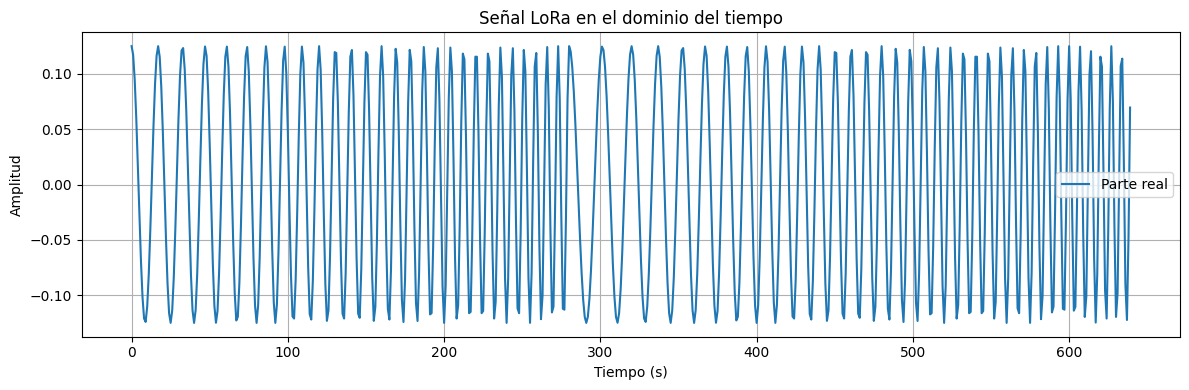

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_domain(waveform):
    signal = waveform.flatten()
    num_samples = signal.size

    # Vector de tiempo
    t = np.arange(num_samples)

    plt.figure(figsize=(12, 4))
    plt.plot(t, signal.real, label='Parte real')
    plt.title('Señal LoRa en el dominio del tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
wave = waveform_former(numero_paquetes, SF , symbols,oversampling=10)
plot_frequency_domain(wave)

### n-Tuple former

#### Proyección de la señal en la recepción de LoRa

En la modulación LoRa (Long Range), la detección del símbolo transmitido en el receptor se realiza proyectando la señal recibida sobre una base ortonormal de señales conocidas. Esta proyección no es otra cosa que el **producto interno** entre la señal recibida y los posibles "chips" o símbolos de la base.

La interpretación geométrica de este producto interno es sencilla: mientras **mayor sea el valor absoluto del producto interno**, **mayor es la similitud** entre la señal recibida y el símbolo proyectado. De este modo, el receptor selecciona el índice de la base que produce la mayor correlación (mayor valor del producto interno) como el símbolo recibido.

#### Cómputo de la proyección

La proyección de la señal $r(nT_s + kT)$ sobre un elemento de la base $c(nT_s + kT)|_{s(nT_s) = p}$ se define como:

$$
\langle r(nT_s + kT), c(nT_s + kT)|_{s(nT_s) = p} \rangle = \sum_{k=0}^{2^{SF}-1} r(nT_s + kT) \cdot e^{-j 2\pi \frac{k^2}{2^{SF}}} \cdot \frac{1}{\sqrt{2^{SF}}} e^{-j 2\pi \frac{pk}{2^{SF}}}
$$

Esto se puede descomponer en los siguientes pasos:

1. **Dechirping (multiplicación con el chirp inverso)**:

   Este es un paso clave del receptor LoRa. La señal transmitida es un chirp ascendente (frecuencia creciente), y al multiplicarla por un chirp descendente (frecuencia decreciente), se obtiene una señal de frecuencia constante (o casi constante) que contiene el símbolo transmitido codificado en la frecuencia resultante.

   En términos matemáticos:

   $$
   d(nT_s + kT) = r(nT_s + kT) \cdot e^{-j 2\pi \frac{k^2}{2^{SF}}}
   $$

   Esta operación "plana" el chirp, haciendo que el contenido de frecuencia del símbolo sea fácil de identificar.

2. **Transformada de Fourier discreta (DFT)**:

   Una vez realizada la operación de dechirping, la señal resultante contiene una componente dominante en la frecuencia correspondiente al símbolo transmitido. Entonces, aplicar la DFT revela en qué valor de frecuencia está presente esa componente:

   $$
   s(nT_s) = \frac{1}{\sqrt{2^{SF}}} \sum_{k=0}^{2^{SF}-1} d(nT_s + kT) \cdot e^{-j 2\pi \frac{pk}{2^{SF}}}
   $$

   Este paso es computacionalmente eficiente y se puede implementar con una FFT.



En resumen, el receptor LoRa determina qué símbolo se ha transmitido comparando la señal recibida con todos los posibles símbolos, utilizando productos internos (proyecciones) y eligiendo el máximo. Esta correlación se lleva a cabo tras compensar la señal con un chirp inverso y aplicar la DFT.


In [4]:
# Se crea un down chirp por cada simbolo
def base_down_chirp(sf,numero_paquetes):
    M = 2**sf
    norm = 1 / np.sqrt(M)
    base_down_chirp =  np.zeros((numero_paquetes, M), dtype=complex)
    for n in range(numero_paquetes):
        for k in range(M):
            base_down_chirp[n, k] = norm*np.exp(-1j * 2 * np.pi * (k**2 / (2**sf))) 
    return base_down_chirp

def base_down_chirp_vectorized(sf, numero_paquetes):
    M = 2**sf
    norm = 1 / np.sqrt(M)

    # vector de índices k = [0,1,...,M-1]
    k = np.arange(M)

    # calcular un único down‑chirp de longitud M
    single_chirp = norm * np.exp(-1j * 2 * np.pi * (k**2 / M))

    # replicar en numero_paquetes filas sin bucles
    base_down_chirp = np.tile(single_chirp, (numero_paquetes, 1))

    return base_down_chirp

# Calculo de la probabilidad de error de simbolo
def SER(enviados, recibidos):
    # Contamos diferencias y calculamos probabilidad de error
    errores = np.sum(enviados != recibidos)

    # Total de bits
    total_simbolos = enviados.size
    
    # Tasa de error
    pe = errores / total_simbolos
    return pe
    #print(f"\nLa Probabilidad de error de simbolo es: {pe:.6f}")

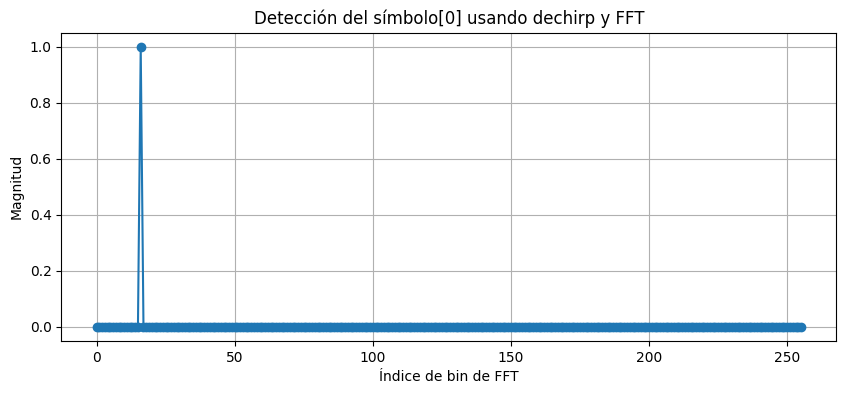

Símbolos detectados: [ 16   0   7 240]
Símbolos enviados: [ 16   0   7 240]


np.float64(0.0)

In [5]:
dechirped =  base_down_chirp(SF,numero_paquetes)*wave

# FFT para detección de símbolo
D = np.fft.fft(dechirped)
magnitude = np.abs(D)

# Visualización
plt.figure(figsize=(10, 4))
plt.plot(magnitude[0], marker='o')
plt.title('Detección del símbolo[0] usando dechirp y FFT')
plt.xlabel('Índice de bin de FFT')
plt.ylabel('Magnitud')
plt.grid(True)
plt.show()

detected_symbols = np.zeros((numero_paquetes,), dtype=int)  
for n in range(numero_paquetes):
    detected_symbols[n] = np.argmax(magnitude[n])

print("Símbolos detectados:", detected_symbols)
print("Símbolos enviados:", symbols)
SER(symbols,detected_symbols)

### Implementación del ruido del Canal


El SNR está definido **por símbolo**. Esto significa que se compara la energía media de un símbolo transmitido con la potencia del ruido. Sin embargo, en la simulación, los símbolos se representan como una secuencia de $M = 2^{sf}$ muestras, por lo que la energía de ruido total por símbolo debe distribuirse entre todas esas muestras.

##### Cálculo paso a paso de la normalización del ruido:

1. **Cálculo del SNR lineal y varianza por símbolo**:

   $$
   \mathrm{SNR} = 10^{\mathrm{SNR_{dB}}/10}, \quad
   \sigma^2_{\text{símbolo}} = \frac{1}{\mathrm{SNR}}.
   $$

   Suponiendo que cada símbolo se normaliza para tener energía unitaria ($E_s = 1$).

2. **Distribución entre $M$ muestras por símbolo**:

   $$
   \sigma^2_{\text{muestra}} = \frac{\sigma^2_{\text{símbolo}}}{M} = \frac{1}{\mathrm{SNR}\,M}.
   $$

3. **Generación de ruido complejo (I y Q)**:
   Cada componente del ruido complejo reparte la varianza a la mitad:

   $$
   \sigma^2_{I} = \sigma^2_{Q} = \frac{1}{2\,\mathrm{SNR}\,M}.
   $$

Si el símbolo está representado por  $M$ muestras en el tiempo, cada muestra “ve” solo una fracción de esa energía de ruido. Esta estrategia de normalización asegura que, al sumar la energía de ruido sobre las $M$ muestras de cada símbolo, el total coincida con el nivel de ruido correspondiente al SNR especificado. 


In [6]:
def additive_white_gaussian_noise(SNR_db, sf, num_paquetes) :
    SNR = 10**(SNR_db/10)
    sigma2 = 1/SNR
    # número total de muestras por simbolo enviado
    M = 2**sf 

    # generar ruido complejo AWGN
    # cada componente (I y Q) con varianza sigma2/2
    ruido_I = np.random.randn(num_paquetes, M) * np.sqrt(sigma2/(2*M))
    ruido_Q = np.random.randn(num_paquetes, M) * np.sqrt(sigma2/(2*M))
    noise = ruido_I + 1j*ruido_Q

    return noise

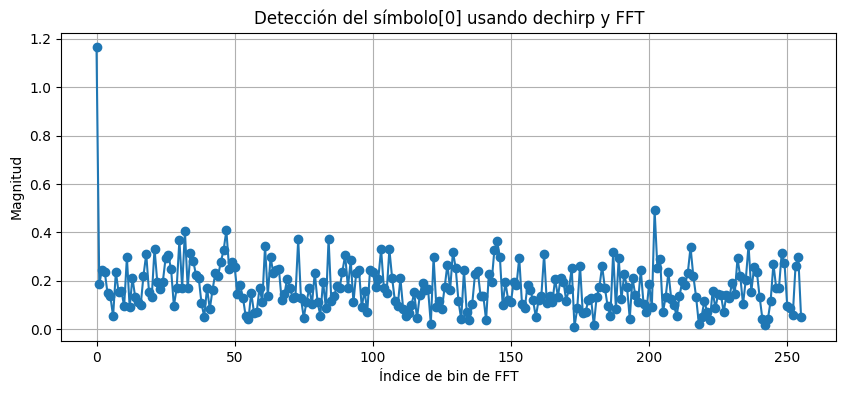

Símbolos detectados: [ 16   0   7 240]
Símbolos enviados: [ 16   0   7 240]


np.float64(0.0)

In [7]:
# señal con ruido
waveform_noisy = wave + additive_white_gaussian_noise(-10,SF,numero_paquetes)

# Dechirp + FFT + detección
dechirped =  base_down_chirp(SF,numero_paquetes)*waveform_noisy
D = np.fft.fft(dechirped)
magnitude = np.abs(D)

# Visualización
plt.figure(figsize=(10, 4))
plt.plot(magnitude[1], marker='o')
plt.title('Detección del símbolo[0] usando dechirp y FFT')
plt.xlabel('Índice de bin de FFT')
plt.ylabel('Magnitud')
plt.grid(True)
plt.show()

detected_symbols = np.zeros((numero_paquetes,), dtype=int)  
for n in range(numero_paquetes):
    detected_symbols[n] = np.argmax(magnitude[n])

print("Símbolos detectados:", detected_symbols)
print("Símbolos enviados:", symbols)
SER(symbols,detected_symbols)

bits_recv = decoder(detected_symbols, SF)
BER(bits_send, bits_recv)

### Implementacion del canal selectivo en frecuencia

In [ ]:
import numpy as np
from scipy.signal import lfilter

def freq_sel(SNR_db, sf, num_paquetes, x):
    # Parámetros
    SNR = 10**(SNR_db/10)
    sigma2 = 1/SNR
    M = 2**sf
    
    # Definir el canal FIR de dos taps
    h0 = np.sqrt(0.8)
    h1 = np.sqrt(0.2)
    
    # Defino el filtro h = [h0, h1]
    b = [np.sqrt(0.8), np.sqrt(0.2)]
    a = [1]  # filtro FIR

    # Aplico el mismo filtro a cada fila
    y_filter = np.array([lfilter(b, a, x[n,:]) for n in range(num_paquetes)])

    # Generar ruido AWGN (I/Q con varianza sigma2/2)   
    ruido_I = np.random.randn(num_paquetes, M) * np.sqrt(sigma2/(2*M))
    ruido_Q = np.random.randn(num_paquetes, M) * np.sqrt(sigma2/(2*M))
    noise = ruido_I + 1j*ruido_Q
    
    # Señal recibida = paso por canal + ruido
    y = y_filter + noise
    
    return y


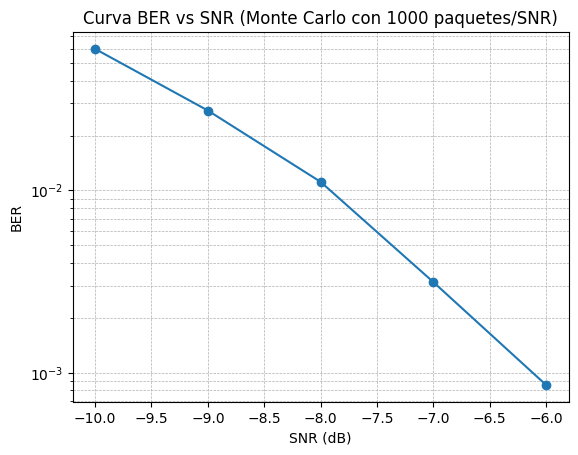

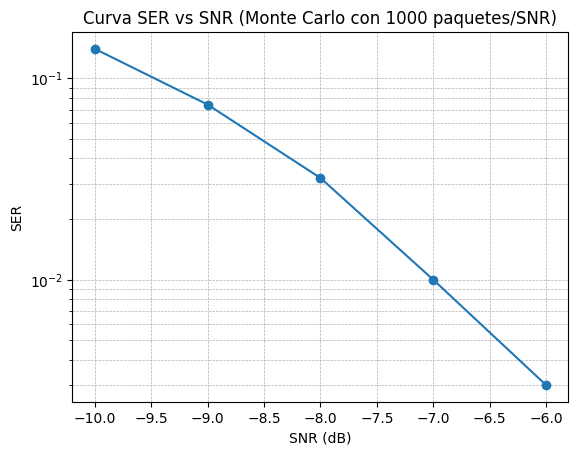

In [ ]:

def simulación(SF, PACKETS_PER_SNR, FREQ_SEL,SNR_db_range):  
    BERs = []
    SERs = []

    for snr_db in SNR_db_range:

        # Bits transmitidos
        bits_transmitidos     = generate_random_uniform_bits(S_F, PACKETS_PER_SNR, 0.5)
        simbolos_transmitidos = encoder(bits_transmitidos, S_F)

        # Generar señal ruidosa para un paquete
        if(FREQ_SEL):
            señal_ruidosa = freq_sel(snr_db,S_F, PACKETS_PER_SNR,waveform_former_vectorized(S_F , simbolos_transmitidos)) 
        else:
            señal_ruidosa = waveform_former_vectorized(S_F, simbolos_transmitidos) + additive_white_gaussian_noise(snr_db, S_F, PACKETS_PER_SNR)

        # Dechirp + FFT + detección
        dechirped_signal = base_down_chirp_vectorized(S_F, PACKETS_PER_SNR) * señal_ruidosa
        DFT              = np.fft.fft(dechirped_signal)
        magnitud         = np.abs(DFT)

        simbolos_recibidos = np.zeros((PACKETS_PER_SNR,), dtype=int)  
        for n in range(PACKETS_PER_SNR):
            simbolos_recibidos[n] = np.argmax(magnitud[n])

        # Decodificar y contar errores
        bits_recibidos = decoder(simbolos_recibidos, S_F)
        BERs.append(BER(bits_transmitidos, bits_recibidos))
        SERs.append(SER(simbolos_transmitidos,simbolos_recibidos))

        return BERs, SERs
    
# Parámetros de la simulación
BERs = []
SERs = []
PACKETS_PER_SNR = 10000                  # número de paquetes a transmitir por cada SNR
S_F = 7
SNR_db_range   = np.arange(-10, -5, 1)   # de -10 a -6 dB

FREQ_SEL = True  # True para canal selectivo, False para AWGN puro
BERs, SERs = simulación(S_F, PACKETS_PER_SNR, FREQ_SEL, SNR_db_range)


plt.figure()
plt.semilogy(SNR_db_range, BERs, marker='o')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title(f'Curva BER vs SNR (Monte Carlo con {PACKETS_PER_SNR} paquetes/SNR)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

plt.figure()
plt.semilogy(SNR_db_range, SERs, marker='o')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title(f'Curva SER vs SNR (Monte Carlo con {PACKETS_PER_SNR} paquetes/SNR)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
